**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Marcos Ricardo Omena de Albuquerque Maximo

Gabriel Adriano de Melo


**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o "ESCREVA SUA RESPOSTA AQUI", além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automatizada e manual. O sistema de correção automatizada executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois não adianta recriar a célula porque perdeu o ID. Ou então você baixa e abre o notebook como texto (é um JSON) e readiciona o campo de ID. Neste ano nós também colocamos um comentário nessas células que é igual ao ID delas, para ser um failsafe em caso de sumirem com o ID das células, então NÃO apaguem esse comentário com ID.

Os notebooks vocês podem alterar à vontade, podem criar novas células, modificar as existentes, apagar (a menos das células de correção). O corretor automático executará todas as células e verificará a presença de erro nos `asserts`, depois haverá a correção manual das questões com apreciação da resposta e comentários gerados em HTML. Se ele não achar a célula com os asserts, fica sem a nota da questão, se ele não achar a célular com a questão, fica sem os comentários. Mas vocês podem escreve sim código fora dos espaço delemitado pelo `ESCREVA SEU CÓDIGO AQUI` sem problemas, só não altera a assinatura da função. Esse espaço foi pensado para facilitar a sua implementação.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada Lab. Os comandos que se inicial por ! (ponto de exclamação) são de bash e também podem ser executados no terminal linux, que justamente instalam as dependências.

---

# Laboratório 2 - nanoGrad

**NÃO** use LLMs (ChatGPT).  **NÃO** pesquise a resposta na internet (**NÃO** copie o código de repositórios de autograd, microGrad, nanoGrad, femtoGrad ...).
**Pode** olhar a documentação do NumPy (mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências). Este laboratório foi baseado no material do [Andrej Karpathy](https://github.com/karpathy). Por isso você não pode copiar o código dele, mas pode assistir as [aulas dele](https://www.youtube.com/watch?v=VMj-3S1tku0) e também outras aulas na internet, só não copie o código sem pensar/sem entender efetivamente o que ele faz.


Neste laboratório vamos implementar o nosso próprio framework para calcular os gradientes automaticamente. O importante aqui é que você entenda a intuição de que a rede neural é um grafo computacional, e cada nó desse grafo computacional representa um valor (estado intermediário) que sofre operações (arestas direcionadas) e que resulta em novos valores (nós). Tudo isso no cálculo direto.

Mas também temos o nosso cálculo dos gradientes (por backpropagation) que é fazer o caminho reverso do que fizemos no nosso cálculo direto.

E no final, todo esse trabalho tem o objetivo de otimizarmos os nossos parâmetros: atualizá-los na direção do gradiente, isto é, mudar os parâmetros um pouquinho para cima ou para baixo a depender de que essa mudança melhore a nossa função custo (aumentar ou diminuir).

In [1]:
# # from pathlib import Path             # Já importado pelo fastai
# # from typing import Callable          # Já importado pelo fastai
# # import numpy as np                   # Já importado pelo fastai
# # import pandas as pd                  # Já importado pelo fastai
# # from PIL import Image                # Já importado pelo fastai
# # from matplotlib import pyplot as plt # Já importado pelo fastai
# from fastai.vision.all import *        # fastai==2.7.12
# import cv2                             # opencv-contrib-python-headless==4.8.0.74
# # 



# # Caso esteja executando o notebook localmente, reimplementa o cv2_imshow
# from IPython.utils import io
# from IPython.display import display
# import warnings
# try:
#     from google.colab.patches import cv2_imshow
# except:
#     def cv2_imshow(img):
#         display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# # Faz o numpy imprimir mais números por linha
# np.set_printoptions(edgeitems=40, linewidth=130)

# import seaborn

Importar as bibliotecas, vamos usar apenas o NumPy para fazer a nossas operações, o graphviz é para plotar o grafo, o matplotlib para plotar os gráficos, o fastcore é só para usarmos o método de patch_to (monkey patching para alterar uma classe já existente), anotações de tipos em Python 3.8, e o dataset sintético.

In [2]:
# Python 3.10.12 ou >3.8
import numpy as np                      # numpy==1.22.4
from graphviz import Digraph            # graphviz==0.20.1
import matplotlib.pyplot as plt         # matplotlib==3.7.1
from fastcore.basics import patch_to    # fastcore==1.5.29


from typing import Tuple, Callable, Union, Set, List
from sklearn.datasets import make_moons # sklearn==1.3.0

np.set_printoptions(precision=4) # pode mudar aqui se quiser
plt.style.use('seaborn-v0_8-darkgrid')

Dados sintéticos para treinar a rede neural (além de mudar o diretório do notebook para o /content , que é o que o Colab já faz):

In [3]:
# dataset_lab

matriz_X, matriz_Y = make_moons(n_samples=200, noise=0.15, random_state=25)
matriz_Y = matriz_Y.reshape(-1, 1).astype(np.float64)
%cd /content

/content


## Nós e Operações Computacionais Básicos (2 pontos)

**Explicação sobre o assunto**

O elemento mais básico de um grafo computacional são os seus nós (bolinhas), que na nossa representação, define um valor numérico (ou n-dimensional).

O que dá 'liga' aos elementos são as suas conexões (arestas, setinhas), que na nossa representação, define a operação (transformação) que o valor sofre.

Com as definições de nós e arestas direcionadas podemos construir um grafo direcionado que consegue representar uma função computável e, a menos do controle de fluxo abitrário (loops com condições de parada não-fixas), também um programa 'bem comportado'.

O nível de granularidade dos nós e das operações (apenas um escalar vs matriz n-dimensional) depende do gosto do 'freguês', inclusive, um nó poderia ser uma rede neural inteira! Só precisamos saber calcular a derivada da saída com relação à entrada do nó (isto é o jacobiano para o caso n-dimensional).

Mas para não assustar (espero ter motivado), vamos começar do caso mais simples: um nó sendo apenas um escalar e com operações sobre valores escalares.

Observe com atenção o código abaixo, é simples, mas é crucial que você entenda o funcionamento do Nó Computacional e do seu contexto, que simplesmente guarda uma referência para os seus pais e para a operação que os pais fizeram para poder gerá-lo. Apenas essas informações (além do valor) já é o suficiente para definir uma estrutura computacional de grafo direcionado.

O método `__init__` é o inicializador da classe de Python (quando instanciamos um novo objeto da classe e passamos argumentos).

O método `__add__` é o que Python chama quando fazemos uma operação de `+` entre dois objetos da mesma classe (`NoComp(1) + NoComp(3)`).

Semelhantemente o método `__mul__` é para multiplicação (operador `*`), isto é, `NoComp(5) + NoComp(7)`.

E finalmente o `tanh` é uma função com nome qualquer, mas que no caso implementa a função tangente hiperbólica, isto é, `NoComp(1.2).tanh()`.

Essas operações todas devem resultar em um novo objeto do `NoComp`, que é a questão que vocês vão desenvolver abaixo.

A lista de filhos que colocamos é opcional no sentido que a própria construção do grafo (por meio das operações) já induz a noção de filhos (cuidado se for pela aula do Andej que ele troca pai por filho). Mas deixar a lista explícita fica mais cômodo para imprimir o grafo ou se quisermos reaproveitá-lo depois (em vez de construir um novo grafo).

In [4]:
class Contexto:
    """Situa o nó (quem o gerou): os seus pais e a operação que eles fizeram"""
    
    def __init__(self, pais:Tuple['NoComp'], operacao: Callable):
        self.pais = pais
        self.operacao = operacao

class NoComp:
    """Nó Computacional que realiza operações básicas, armazena o seu valor, gradiente e contexto no grafo"""
    
    def __init__(self, valor, ctx:Union[Contexto,None]=None, nome_visual:str=''):
        self.valor = valor
        self.ctx = ctx
        self.nome_visual = nome_visual
        self.gradiente = np.zeros_like(self.valor) if type(self.valor) == np.ndarray else 0
        self.filhos = [] # Essa lista de filhos é opcional
        if ctx is not None:
            for pai in ctx.pais:
                pai.filhos.append(self)

    def __add__(self, outro_noh):
        contexto_filho = Contexto((self, outro_noh), adicao)
        filho = adicao(contexto_filho)
        return filho

    def __mul__(self, outro_noh):
        return multiplicacao(Contexto((self, outro_noh), multiplicacao))
    
    def __matmul__(self, outro_noh):
        return multi_matrici(Contexto((self, outro_noh), multi_matrici))

    def tanh(self):
        return tangente_hipe(Contexto((self,), tangente_hipe))

Você pode estar se perguntando agora o porque de guardarmos a operação no contexto e também o que é o `self.gradiente`, mas nós vamos usá-los para na próxima tarefa (retropropagação).

Observe a criação de um novo valor abaixo (sem pais), para você que ainda vai se habituar:

In [71]:
# Esse código aqui é só para imprimir na tela 😜
@patch_to(NoComp) # O patch_to altera a classe 😊
def __str__(self: NoComp):
    return f"{{ {self.nome_visual} | valor {self.valor} }}"

@patch_to(NoComp) # O patch_to altera a classe 😊
def __repr__(self: NoComp):
    return f"NóComputacional({str(self)})"

Cria um novo nó computacional, veja como é 'legal' o valor que ele imprime na célula:

In [72]:
noh_teste = NoComp(12.19, nome_visual='😇')
noh_teste

NóComputacional({ 😇 | valor 12.19 })

Ainda não podemos fazer operações, você ainda vai implementar a seguida, mas podemos acessar os seus valores dessa forma:

In [73]:
noh_teste.valor

12.19

**Enunciado da Questão**

Gentilmente, o código básico de um nó computacional (e de seu contexto) já foi cedido (poderia ter sido uma questão por si só).

Você precisa apenas implementar as operações básicas de adicão, de multiplicação e de uma função de ativação tangente hiperbólica. Para a `tanh`, use a função `np.tanh` do NumPy (não use `math.`)

**NÃO** use LLMs (ChatGPT).  **NÃO** pesquise a resposta na internet (**NÃO** copie o código de repositórios de autograd, microGrad, nanoGrad, femtoGrad ...).
**Pode** olhar a documentação do NumPy (mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
A resposta é simplesmente uma linha: crie um novo nó, com o valor correto (é a soma ou a multiplicação ou o np.tanh dos valores dos pais) e com o contexto correto (o ctx que já foi passado como argument).

Por enquanto estamos trabalhando apenas com escalares, mas utilize funções vetorizáveis `np.tanh` e as operações de `+` e `*` que são vetorizáveis, para ficar mais fácil as outras questões.
</p>
</details>

In [74]:
# questao_computa_basico

def adicao(ctx: Contexto, gradiente=None) -> NoComp:
    """ Cria um novo nó computacional cujo valor é a soma dos valores de seus pais
    
    :param ctx: Contexto que contém os dois pais que irão gerar o novo nó.
    :param gradiente: Não se preocupe com ela agora, é sempre None (nesta primeira fase)
    Há apenas dois pais SEMPRE, não precisa se preocupar.
    
    Retorna um novo nó computacional, um objeto do tipo NoComp.
    """
    if gradiente is None:
      return NoComp(ctx.pais[0].valor + ctx.pais[1].valor, ctx)
    else:
        retropropaga_adicao(ctx, gradiente)

def multiplicacao(ctx: Contexto, gradiente=None) -> NoComp:
    """ Igual a de cima, mas agora é multiplicação """
    if gradiente is None:
      return NoComp(ctx.pais[0].valor * ctx.pais[1].valor, ctx)
    else:
        retropropaga_multiplicacao(ctx, gradiente)

def tangente_hipe(ctx: Contexto, gradiente=None) -> NoComp:
    """ Cria um novo nó computacional cujo valor é a tangente hiperbólica do valor do pai
    
    :param ctx: Contexto que contém o único pai que irá gerar o novo nó.
    Há apenas UM pai SEMPRE, não precisa se preocupar. Utilize np.tanh.
    
    Retorna um novo nó computacional, um objeto do tipo NoComp.
    """
    if gradiente is None:
      return NoComp(np.tanh(ctx.pais[0].valor), ctx)
    else:
        retropropaga_tangente_hipe(ctx, gradiente)

In [75]:
# testa_computa_basico

# Coloquei muitos testes para vocês não errarem...
raiz1 = NoComp(12)
raiz2 = NoComp(19)
raiz3 = NoComp(25)
ctx_testa_manual1 = Contexto((raiz1, raiz2), adicao)
ctx_testa_manual2 = Contexto((raiz1, raiz2), multiplicacao)
ctx_testa_manual3 = Contexto((raiz3,)      , tangente_hipe)
assert type(adicao       (ctx_testa_manual1)) == NoComp
assert type(multiplicacao(ctx_testa_manual2)) == NoComp
assert type(tangente_hipe(ctx_testa_manual3)) == NoComp
assert type(adicao       (ctx_testa_manual1).ctx) == Contexto
assert type(multiplicacao(ctx_testa_manual2).ctx) == Contexto
assert type(tangente_hipe(ctx_testa_manual3).ctx) == Contexto
assert abs(adicao       (ctx_testa_manual1).valor -  31) < 1e-9
assert abs(multiplicacao(ctx_testa_manual2).valor - 228) < 1e-9
assert abs(tangente_hipe(ctx_testa_manual3).valor -   1) < 1e-9

# Agora fica legal, observe, estamos montando o grafo:
a = raiz1 + raiz2
b = raiz2 * raiz3
c = a + b * a + b * b
d = c.tanh()
e = NoComp(1.3).tanh()
f = NoComp(1.3) + NoComp(4.1) * NoComp(-1.9) + NoComp(0).tanh()

assert abs(a.valor -     31) < 1e-9
assert abs(b.valor -    475) < 1e-9
assert abs(c.valor - 240381) < 1e-9
assert abs(d.valor -      1) < 1e-9
assert abs(e.valor - 0.86172315931) < 1e-9
assert a.ctx.pais[0] == raiz1
assert a.ctx.pais[1] == raiz2
assert len(a.ctx.pais) == 2
assert b.ctx.pais[0] == raiz2
assert b.ctx.pais[1] == raiz3
assert len(b.ctx.pais) == 2
assert d.ctx.pais[0] == c
assert len(d.ctx.pais) == 1
assert abs(f.valor + 6.49) < 1e-9

# Deve abstrair os valores n-dimensionais:
raizm = NoComp(np.array([[1, 34, 4], [-1, -3, 8]]))
contasm = raizm + raizm * raizm.tanh()
assert np.linalg.norm(contasm.valor - np.array((
      [[ 1.7616e+00,  6.8000e+01,  7.9973e+00],
       [-2.3841e-01, -1.4836e-02,  1.6000e+01]]))) < 1e-4


Eu coloquei um zilhão de testes aí em cima, por que se você errar essa questão, você erra o lab inteiro. Tente entende o que cada teste desses está fazendo. Por exemplo, para comparar dois números de pontos flutuantes nós verificamos se a diferença entre eles está dentro de um delta.

Bem, agora que você implementou as operações básicas, você merece ver o grafo resultante.

Só vamos primeiro salvar o nome das variáveis que declaramos anteriormente como também o valor da string nome_visual dos nossos Nós Computacionais. E também vamos definir um nome mais sucinto para os nossos operatores.

In [76]:
for nome, obj in list(globals().items()):
    if type(obj) == NoComp:
        obj.nome_visual = nome

nomes_op = {adicao: '+', multiplicacao: '*', tangente_hipe: 'tanh'}

E agora visualizamos o grafo com a biblioteca graphviz. Salvamos essa função como método da classe `NoComp`.

Perceba como nossos nós são os retângulos com os cantos arredondados, há nós de contas intermediárias, sem nomes, e as operações são as arestas. Olhe por exemplo que no caso do valor `b`, há duas arestas saindo dele próprio para um mesmo nó intermediário (o caso de `b*b`), é muito importante ter cuidado nisso durante a implementação do backpropagation na próxima parte.

Inclusive, esse código do `desenha` já é uma forma de percorrer o gráfico (recursivamente), mas que foi implementado em profundidade e não em largura. Além disso, ele não repete elementos que já foram visitados (`ja_desenhados`).

In [77]:
@patch_to(NoComp)
def desenha(self: NoComp, grafo_visual: Union[Digraph,None]=None, ja_desenhados: Union[Digraph, Set]=None):
    ja_desenhados = ja_desenhados or set()
    if grafo_visual is None:
        grafo_visual = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        grafo_visual.attr('node', shape='record', style='rounded')
    if self in ja_desenhados:
        return grafo_visual
    grafo_visual.node(str(id(self)), str(self))
    ja_desenhados.add(self)
    if self.ctx is not None:
        for pai in self.ctx.pais:
            grafo_visual.edge(str(id(pai)), str(id(self)), nomes_op[self.ctx.operacao])
            pai.desenha(grafo_visual, ja_desenhados)
    return grafo_visual

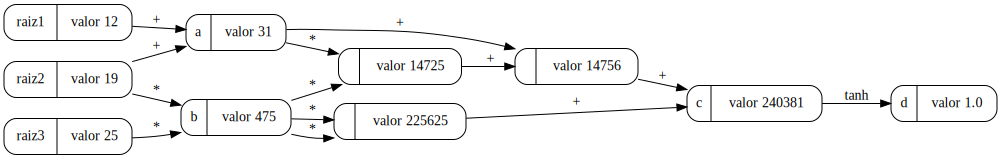

In [78]:
d.desenha()

**BIZU PARA A PRÓXIMA QUESTÃO**

Vou deixar aqui essa outra implementação que percorre o grafo em largura, como bizu para a próxima questão (para facilitar a vida). Observe que a recursão aqui perde um pouco o 'fôlego' e é substituída mais claramento por um loop. A intuição para isso é que agora temos mais uma fila (é uma lista em Python) `a_desenhar` que representa a ordem dos próximos nós a serem visitados. Perceba que novamente não desenhamos nós que já foram desenhados (a implementação mais eficiente disso seria com uma flag, mas usamos um `set()` em Python que é mais lento mas fica mais fácil para não precisar acrescentar mais atributos ao nó).

In [79]:
@patch_to(NoComp)
def desenha(self: NoComp, grafo_visual:Union[Digraph,None]=None):
    if grafo_visual is None:
        grafo_visual = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        grafo_visual.attr('node', shape='record', style='rounded')
    grafo_visual.node(str(id(self)), str(self))
    ja_desenhados = set()
    a_desenhar = [self]
    while len(a_desenhar) > 0:
        atual = a_desenhar.pop(0)
        if atual in ja_desenhados:
            continue
        if atual.ctx is not None:
            a_desenhar.extend(atual.ctx.pais)
            for pai in atual.ctx.pais:
                grafo_visual.edge(str(id(pai)), str(id(atual)), nomes_op[atual.ctx.operacao])
        grafo_visual.node(str(id(atual)), str(atual))
        ja_desenhados.add(atual)
    return grafo_visual

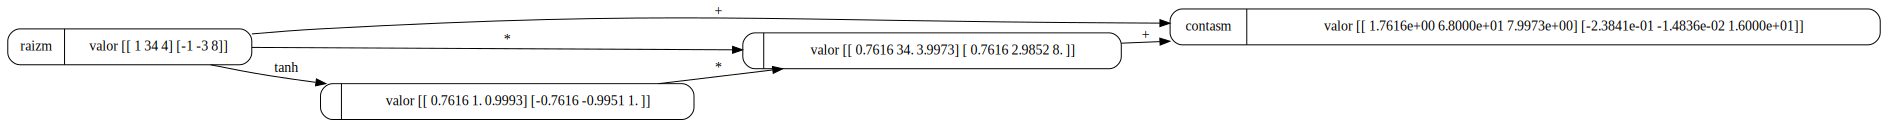

In [80]:
contasm.desenha()

## Retropropagação Básica (3 pontos)

**Explicação sobre o assunto**



Temos que inicializar o nosso atributo dos gradientes (inicialmente estava `None`, mas depois já copiei pro init). Vamos fazer logo recursivamente, para inicializarmos todos os elementos da rede (se começarmos pelo elemento mais 'longe', 'mais no fundo', a loss). Ela já está vector-friendly utilizando o `np.zeros_like` do NumPy.

Observe que essa função `inicializa_gradiente` percorre o grafo em profundidade.

In [81]:
@patch_to(NoComp)
def inicializa_gradiente(self: NoComp):
    self.gradiente = np.zeros_like(self.valor) if type(self.valor) == np.ndarray else 0
    if self.ctx is None:
        return
    for pai in self.ctx.pais:
        if pai.gradiente is None or np.any(pai.gradiente != 0):
            pai.inicializa_gradiente()

**Enunciado da Questão**

Implemente as funções `retropropaga_multiplicacao` e `retropropaga_tangente_hipe` com base no exemplo do `retropropaga_adicao`. Essas funções são chamadas durante a retropropagação e elas acumulam o gradiente que o nó filho tem e passa para os seus pais. Para isso você precisa utilizar a regra da cadeia e saber calcular a *derivada* da operação que vocês fizeram. Essa retropropagação dessas funções é **LOCAL**, isto é, ela opera apenas nos nós imediatos.

Para fazer a retropropagação **GLOBAL**, implemente a função `retropropaga` (que vai ser usada como método da classe NoComp)

Atenção, você deve percorrer o grafo em largura (e não em profundidade), pois temos que garantir que todos os gradientes de um nó já foram completamente acumulados, antes de que ele possa retropropagar para seus pais.

![Animação de Percorrer o Grafo por Largura](https://upload.wikimedia.org/wikipedia/commons/4/46/Animated_BFS.gif)

Atente-se para o fato que os gradientes devem se acumular os gradientes (e não sobreescrevê-los, lembre-se de `b*b` lá de cima (se somar as derivadas de cada um dá $b + b = 2 b$ que é o valor esperado da retropropagação.

Se tiver dúvidas sobre BFS, pode se sentir a vontade para pesquisar outras aulas / materiais (mas não a resposta pronta). Veja por exemplo do [Nipun Ramakrishnan no youtube](https://www.youtube.com/watch?v=xlVX7dXLS64)

**NÃO** use LLMs (ChatGPT).  **NÃO** pesquise a resposta pronta na internet (**NÃO** copie o código de repositórios de autograd, microGrad, nanoGrad, femtoGrad ...).
**Pode** olhar a documentação do NumPy (mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
Para as questões do `retropropaga_multiplicacao` e do `retropropaga_tangente_hipe` basta modificar o gradiente dos seus pais de acordo com a regra da cadeia e a derivada analítica da função. Não se esqueça que os gradientes devem ser acumulados, e não sobreescritos.
    
A derivada da multiplicação é o outro elemento que está multiplicando.

A derivada de tanh(x) é (1 - tanh(x)**2), use np.tanh e **2 para x².

Para a questão do `retropropaga` olhe a função do desenha que implementei duas vezes justamente para você ficar de bizu (a última implementação é por largura), basta você verificar que as operações são exatamente as mesmas (só cuidado para não deixar o loop mais interno, porque o retropropaga_adicao/multiplicacao/tangente_hipe já retropropaga um nível para todos os pais.
</p>
</details>

In [82]:
# questao_retropropaga_basico

def retropropaga_adicao(ctx: Contexto, gradiente: Union[float,np.ndarray]):
    """ Esse eu deixei de DICA, para dar uma dica ainda maior do que fazer 
        Perceba que o valor da derivade de c = a + b é 1 para dc/db e dc/da"""
    ctx.pais[0].gradiente += gradiente * 1
    ctx.pais[1].gradiente += gradiente * 1

def retropropaga_multiplicacao(ctx: Contexto, gradiente: Union[float,np.ndarray]):
    """ Retropropaga o gradiente localmente, da multiplicação, apenas para os pais imediatos 
    
    :param ctx: Contexto do nó atual que está retropropagando para os nós que o gerou (seus pais)
    :param gradiente: Valor float ou matriz numpy que representa o gradiente que o nó atual tem
    
    Essa função não retorna nenhuma valor, mas modifica os valores dos gradientes dos ctx.pais.
    """
    ctx.pais[0].gradiente += gradiente * ctx.pais[1].valor
    ctx.pais[1].gradiente += gradiente * ctx.pais[0].valor

def retropropaga_tangente_hipe(ctx: Contexto, gradiente: Union[float,np.ndarray]):
    """ Retropropaga o gradiente localmente, da tangente hiperbólica, apenas para o seu pai imediato
    
    :param ctx: Contexto do nó atual que está retropropagando para o nó que o gerou (seu pai)
    :param gradiente: Valor float ou matriz numpy que representa o gradiente que o nó atual tem
    
    Essa função não retorna nenhuma valor, mas modifica o valor do gradiente do ctx.pais[0].
    """
    ctx.pais[0].gradiente += gradiente * (1 - (np.tanh(ctx.pais[0].valor))**2)

@patch_to(NoComp)
def retropropaga(self: NoComp, gradiente: Union[float, np.ndarray] = None):
    """ Retropropaga o gradiente globalmente, a todos os seus antepassados até as raízes.
    
    :param self: Instância de NoComp
    :param gradiente: Float ou matrix numpy que representa o gradiente a ser retropropagado,
                      se não for passado, é assumido como valor unitário (ou matriz)
    
    Essa função não retorna nenhuma valor, mas modifica os valores dos gradientes de todos os nós antecessores.
    """
    self.gradiente = gradiente or np.ones_like(self.valor) if type(self.valor) == np.ndarray else 1
    if gradiente is None and np.size(self.gradiente) > 1:
        print('ATENÇÃO, essa função apenas calcula os gradientes, precisamos de um escalar, (o jacobiano é interno), assumimos pesos unitários para as dimensões')
    ja_retropropagados = set()
    a_retropropagar = [self]
    while len(a_retropropagar) > 0:
      atual = a_retropropagar.pop(0)
      if atual in ja_retropropagados:
        continue
      if atual.ctx is not None:
        a_retropropagar.extend(atual.ctx.pais)
        atual.ctx.operacao(atual.ctx, atual.gradiente)
      ja_retropropagados.add(atual)

In [83]:
# testa_retropropaga_basico

m = NoComp(0.4, nome_visual='m')
b = NoComp(-0.1, nome_visual='b')
x = NoComp(8.1, nome_visual='x')
y = m * x + b; y.nome_visual = 'y'
y.inicializa_gradiente()
y.retropropaga()
assert abs(b.gradiente - 1  ) < 1e-9
assert abs(x.gradiente - 0.4) < 1e-9
assert abs(m.gradiente - 8.1) < 1e-9

def testa_func(dw01=0, dw02=0, dw11=0, dw22=0, dx2=0):
    x0, x1, x2, x3 = NoComp(1), NoComp(4.1), NoComp(-0.3+dx2), NoComp(2.1)
    w01, w11, w21, w31 = NoComp(0.1+dw01), NoComp(-0.3+dw11), NoComp(-1), NoComp(0.9)
    w02, w12, w22, w32 = NoComp(-0.3+dw02), NoComp(0.5), NoComp(-0.2+dw22), NoComp(0.4)
    z1 = x0*w01 + x1*w11 + x2*w21 + x3*w31
    z2 = x0*w02 + x1*w12 + x2*w22 + x3*w32
    a0, a1, a2 = NoComp(1), z1.tanh(), z2.tanh()
    wf0, wf1, wf2 =  NoComp(0.2), NoComp(-0.8), NoComp(0.4)
    zf = a0*wf0 + a1*wf1 + a2*wf2
    yf = zf.tanh()
    for nome, obj in list(locals().items()):
        if type(obj) == NoComp:
            obj.nome_visual = nome
    return yf, (w01, w02, w11, w22, x2)

yf0,_ = testa_func()
delta = 1e-9
yfdw01, (dw01, _, _, _, _) = testa_func(dw01=delta)
yfdw01.inicializa_gradiente()
yfdw01.retropropaga()
dyfdw01 = (yfdw01.valor - yf0.valor)/delta
assert abs(dyfdw01 - dw01.gradiente) < 1e-6
yfdx2, (_, _, _, _, dx2) = testa_func(dx2=delta)
yfdx2.inicializa_gradiente()
yfdx2.retropropaga()
dyfdx2 = (yfdx2.valor - yf0.valor)/delta
assert abs(dyfdx2 - dx2.gradiente) < 1e-6

# Deve abstrair os valores n-dimensionais:
raizm = NoComp(np.array([[0.6, -1.8, -0.5], [-0.2, 0.4, 1.2]]))
contasm = raizm + raizm * raizm.tanh()
contasm.inicializa_gradiente()
contasm.retropropaga()
assert np.linalg.norm(raizm.gradiente - np.array([
    [ 1.96399622455, -0.13321108611,  0.14465897626],
    [ 0.61041608318,  1.72220447669,  2.19967860246]])) < 1e-6


ATENÇÃO, essa função apenas calcula os gradientes, precisamos de um escalar, (o jacobiano é interno), assumimos pesos unitários para as dimensões


Como vamos calcular os gradientes, seria legal se pudéssemos ver o seu valor no grafo também:

In [84]:
def limita_str(valor):
    string = str(valor)
    return string if len(string) < 30 else valor.shape

@patch_to(NoComp) # Vamos mostrar os gradientes agora também
def __str__(self: NoComp):
    return f"{{ {self.nome_visual} | valor {limita_str(self.valor)} | grad {limita_str(self.gradiente)}}}"

Se estiver com dificuldades, observe os grafos abaixo, principalmente o primeiro mais simples do $y=m x + b$

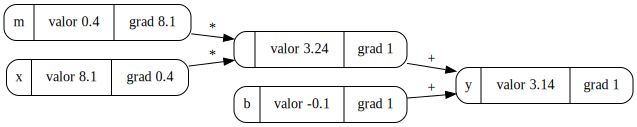

In [85]:
y.desenha()

E agora o grafo maior que é quase como uma implementação de uma pequena rede neural, sendo que cada nó é um neurônio.

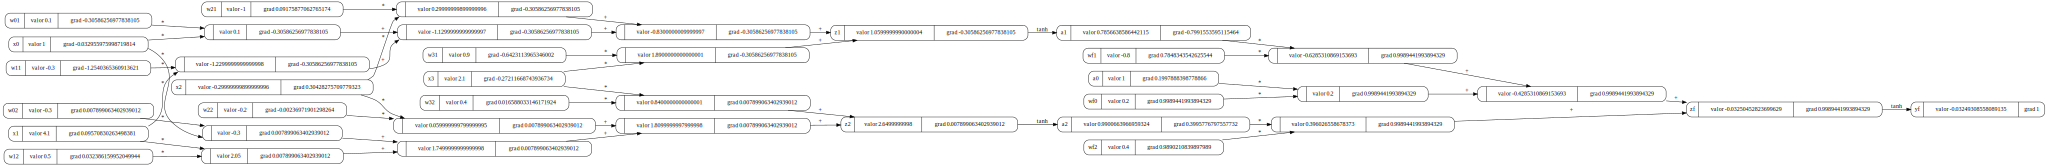

In [86]:
yfdx2.desenha()

Se você não ficou emocionado com esse grafo, você não tem coração...

Tente brincar com ele, mude os valores (recalcule) e repropague e veja o que acontece com os gradientes.

## Operações Vetorizadas (2 pontos)

**Explicação sobre o assunto**

Tratar cada nó como um neurônio separado é muito ineficiente. Podemos fazer toda essa operação de combinação linear (multiplicação pelos pesos e soma) por uma operação de multiplicação matricial.

Assim, retornamos ao mesmo paradigma da primeira questão e da questão anterior, mas agora estamos trabalhando apenas com valores que são matrizes. Inclusive, se você tiver implementado agnosticamente do tipo do valor, as questões anteriores já funcionam com matrizes, sem que você tenha se preocupado com isso.

**Enunciado da Questão**

Implemente a função abaixo, `multi_matrici`, no mesmo estilo das funções da primeira questão (`adicao`, `multiplicacao`, `tangente_hipe`) mas agora os valores dos pais são garantidamente matrizes numpy compatíveis.


**NÃO** use LLMs (ChatGPT).  **NÃO** pesquise a resposta na internet (**NÃO** copie o código de repositórios de autograd, microGrad, nanoGrad, femtoGrad ...).
**Pode** olhar a documentação do NumPy (mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
Observe o que já foi implementado nas questões anteriores.

Verifique se é propagação direta (gradiente is None) ou se é retropropagacao.
Garantidamente ctx.pais são vetores numpy cujas as dimensões estão corretas.
Há apenas DOIS pais, não precisa se preocupar. Utilize @ para operar sobre matrizes numpy.
</p>
</details>

In [87]:
# questao_vetoriza

def multi_matrici(ctx: Contexto, gradiente: np.ndarray = None) -> Union[NoComp, None]:
    """ Cria um novo nó computacional cujo valor é a multiplicação matricial entre os pais. (a ordem importa)
    
    :param ctx: Contexto que contém os dois pais que irão gerar o novo nó.
    
    Verifique se é propagação direta (gradiente is None) ou se é retropropagacao.
    Garantidamente ctx.pais são vetores numpy cujas as dimensões estão corretas.
    Há apenas DOIS pais, não precisa se preocupar. Utilize @ para operar sobre matrizes numpy.
    
    Retorna um novo nó computacional resultad da multiplicação matricial
    """
    if gradiente is None:
      return NoComp(ctx.pais[0].valor @ ctx.pais[1].valor, ctx)
    else:
      retropropaga_multi_matrici(ctx, gradiente)
      
def retropropaga_multi_matrici(ctx: Contexto, gradiente: np.ndarray):
#   print(f'gradiente shape: {gradiente.shape}')
#   print(f'gradiente: {gradiente}')
#   print(f'pais[0] shape: {ctx.pais[0].valor.shape}')
#   print(f'pais[0]: {ctx.pais[0].valor}')
#   print(f'pais[0] transpose shape: {ctx.pais[0].valor.transpose().shape}')
#   print(f'pais[0] transpose: {ctx.pais[0].valor.transpose()}')
#   print(f'pais[1] shape: {ctx.pais[1].valor.shape}')
#   print(f'pais[1]: {ctx.pais[1].valor}')
#   print(f'pais[1] transpose shape: {ctx.pais[1].valor.transpose().shape}')
#   print(f'pais[1] transpose: {ctx.pais[1].valor.transpose()}')
#   print("################")
  ctx.pais[0].gradiente += gradiente @ ctx.pais[1].valor.transpose()
  ctx.pais[1].gradiente += ctx.pais[0].valor.transpose() @ gradiente

def retropropaga_multiplicacao(ctx: Contexto, gradiente: Union[float,np.ndarray]):
    """ Retropropaga o gradiente localmente, da multiplicação, apenas para os pais imediatos 
    
    :param ctx: Contexto do nó atual que está retropropagando para os nós que o gerou (seus pais)
    :param gradiente: Valor float ou matriz numpy que representa o gradiente que o nó atual tem
    
    Essa função não retorna nenhuma valor, mas modifica os valores dos gradientes dos ctx.pais.
    """
    ctx.pais[0].gradiente += gradiente * ctx.pais[1].valor
    ctx.pais[1].gradiente += gradiente * ctx.pais[0].valor


def multiplicacao(ctx: Contexto, gradiente=None) -> NoComp:
    """ Igual a de cima, mas agora é multiplicação """
    if gradiente is None:
      return NoComp(ctx.pais[0].valor * ctx.pais[1].valor, ctx)
    else:
        retropropaga_multiplicacao(ctx, gradiente)


In [88]:
# testa_vetoriza

X = NoComp(np.array([[ 1  ,  4.1, -0.3, 2.1]]), nome_visual='X')
W = NoComp(np.array([[ 0.1, -0.3],
                     [-0.3,  0.5],
                     [-1  , -0.2],
                     [ 0.9,  0.4]]), nome_visual='W')
Z = X @ W; Z.nome_visual='Z'
A = Z.tanh(); A.nome_visual='A'
Wf = NoComp(np.array([[-0.8],[0.4]])); Wf.nome_visual='Wf'
Zf = A @ Wf; Zf.nome_visual = 'Zf'
Yf = Zf.tanh(); Yf.nome_visual='Yf'

Yf.inicializa_gradiente()
Yf.retropropaga()
assert np.linalg.norm(X.gradiente - np.array([
  [-0.0312697368 ,  0.09081125174,  0.28871369872, -0.25819345159]])) < 1e-6

L = Yf @ Yf @ Yf
L.inicializa_gradiente()
L.retropropaga()
assert np.linalg.norm(X.gradiente - np.array([
  [-0.00489385712,  0.0142123771 ,  0.04518501706, -0.04040845851]])) < 1e-6


Vamos atualizar a nossa variável global com os nomes das nossas operações, `nomes_op`, para acrescentar a nossa operação de `@` e imprimir o nosso grafo

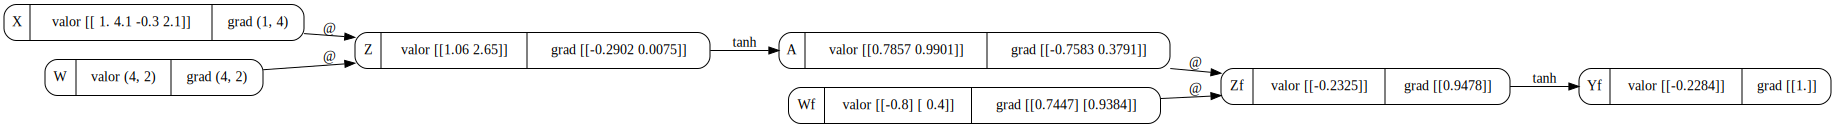

In [89]:
nomes_op[multi_matrici] = '@'

Yf.inicializa_gradiente()
Yf.retropropaga()

Yf.desenha()

## Rede Neural (2 pontos)

**Explicação sobre o assunto**

Agora temos todas as ferramentas a nossa disposição para construírmos a nossa própria rede neural. Veja o exemplo da classe abaixo que recebe uma tupla de inteiros que indica quantos neurônios temos por camada.

Ela guarda os parâmetros que são treináveis, são os nós raízes (folhas da retropropagação), pois se o X mudar eles não mudam (enquanto as ativações são todas recalculadas).

Olha o legal da classe abaixo: quando você invoca um objeto que é instância dela (função `__call__`) ela te retorna um novo nó computacional. É por isso que os frameworks de deep learning tem os 'parênteses duplos', tipo torch.ReLU()(x).

In [90]:
class RedeNeuralSequencial:
    def __init__(self, neuronios_por_camada: Tuple[int]):
        self.pesos_sinapticos, self.bias = constroi_rede_neural_sequencial(neuronios_por_camada)
    
    def __call__(self, x):
        ativacao = x
        for i, (peso, b) in enumerate(zip(self.pesos_sinapticos, self.bias)):
            combinacao_linear = (ativacao @ peso) + b
            ativacao = combinacao_linear.tanh()
            combinacao_linear.nome_visual = f"Z^({i+1})"
            ativacao.nome_visual = f"A^({i+1})"
        return ativacao
    
    def parametros(self):
        return self.pesos_sinapticos + self.bias
    
    def zera_gradientes_parametros(self):
        for parametro in self.parametros():
            parametro.gradiente.fill(0)

Para inicializar os pesos da nossa rede aleatoriamente, já implementamos a função abaixo que amostra de uma distribuição gaussiana com variância escalada pela quantidade de neurônios da camada anterior, isto é, a quantidade de entradas a um neurônio, o seu $fan_{in}$.

In [91]:
def valor_inicial(n_linhas:int, n_colunas:int) -> np.ndarray:
    """ Retorna uma matriz numpy com (n_linhas, n_colunas) inicializada aleatoriamente"""
    shape = (n_linhas, n_colunas)
    if n_linhas == 1:
        return np.zeros(shape, dtype=np.float64)
    return np.random.normal(scale=1/np.sqrt(n_linhas), size=shape)

Além disso, como estamos usando um termo de bias agora (pois não implementamos um nó de concatenação), e pelo fato do NumPy já fazer automaticamente o broadcasting, temos que consertar a nossa função de retropropagação para poder fazer o inverso do broadcasting, isto é, se o broadcasting repete as dimensões, nós temos que reduzi-las (pela soma). Só fizemos isso para a soma e só pensando no caso $(N, M)$, mas se fosse um framework geral, teríamos que pensar também nas outras operações e em dimensões maiores.

In [92]:
def retropropaga_adicao(ctx: Contexto, gradiente):
    for pai in ctx.pais: # Para resolver o broadcasting do bias
        if type(gradiente)==np.ndarray and gradiente.shape[0] > pai.gradiente.shape[0] and pai.gradiente.shape[0] == 1:
            pai.gradiente += gradiente.sum(axis=0)[None]
        else:
            pai.gradiente += gradiente

**Enunciado da Questão**

Implemente a função `constroi_rede_neural_sequencial`.

**NÃO** use LLMs (ChatGPT).  **NÃO** pesquise a resposta na internet (**NÃO** copie o código de repositórios de autograd, microGrad, nanoGrad, femtoGrad ...).
**Pode** olhar a documentação do NumPy (mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
Basta usar a função `.append`, criando novos Nos Computacionais com as dimensões adequadas.
</p>
</details>

In [128]:
# questao_rede_neural


def constroi_rede_neural_sequencial(neuronios_camada: Tuple[int]) -> Tuple[List[NoComp], List[NoComp]]:
    """ Função que constrói os parâmetros de uma rede neural sequencial
    
    :param neuronios_camada: Tupla de inteiros que indica a quantidade de neurônios por camada
    
    Utilize a função valor_inicial para obter uma matriz numpy com valores iniciais de cada camada.
    
    Retorna uma lista de nós que representam o peso sináptico de cada camada e outra lista de nós para os bias
    """
    pesos_sinapticos: List[NoComp] = []
    bias: List[NoComp] = []
      
    for qtd_anterior, qtd_posterior in zip(neuronios_camada, neuronios_camada[1:]):
        bias_atual = NoComp(valor_inicial(1, qtd_posterior))
        bias.append(bias_atual)
        
        peso_atual = NoComp(valor_inicial(qtd_anterior, qtd_posterior))
        pesos_sinapticos.append(peso_atual)
        
    for i, (peso, b) in enumerate(zip(pesos_sinapticos, bias)):
        peso.nome_visual = f"W^({i+1})"
        b.nome_visual = f"B^({i+1})"
        
    return pesos_sinapticos, bias

In [129]:
# testa_rede_neural

np.random.seed(42)
pesos_sinapticos, bias = constroi_rede_neural_sequencial((2, 32, 64, 32, 1))
assert len(pesos_sinapticos) == 4
assert len(bias) == 4
assert pesos_sinapticos[0].valor.shape == (2, 32)
assert pesos_sinapticos[2].valor.shape == (64,32)
assert pesos_sinapticos[3].valor.shape == (32, 1)
assert bias[1].valor.shape == (1, 64)
np.random.seed(42)
w1v = valor_inicial(2, 32)
assert np.all(w1v == pesos_sinapticos[0].valor)


modelo = RedeNeuralSequencial((2, 32, 64, 32, 1))
X = NoComp(np.random.uniform(size=(19, 2)), nome_visual='X')
estimativa = modelo(X); estimativa.nome_visual='Ŷ'
assert estimativa.valor.shape == (19, 1)
estimativa.retropropaga() # Isso imprime a mesagem de atenção, pois não é um escalar

um_res = RedeNeuralSequencial((2, 1))(X)


ATENÇÃO, essa função apenas calcula os gradientes, precisamos de um escalar, (o jacobiano é interno), assumimos pesos unitários para as dimensões


Observe como fica a nossa rede neural sequencial. Atente para o seu grafo e os nomes dos parâmetros, sobretudo os nós que não tem pai (eles são os parâmetros que iremos otimizar, a menos do X que é valor de entrada).

É claro que se um modelo puramente sequencial é um grafo muito simplificado (uma 'tripa').

In [ ]:
estimativa.desenha()

## Gradiente Descendente e Otimização (1 ponto)

**Explicação sobre o assunto**

Agora já temos as nossas ferramentas e o nosso modelo (a faca e o bolo), devemos treiná-lo, isto é, aproveitá-lo.

Para isso vamos definir uma loss, no caso a única que dá para fazer com as operações que temos é a MSE.

Além disso para a função custo, precisamos somar em todas as dimensões, por isso, implementamos ainda a função soma abaixo:

In [ ]:
@patch_to(NoComp)
def soma(self: NoComp):
    return soma_total(Contexto((self,), soma_total))

def soma_total(ctx, gradiente=None):
    if gradiente is None:
        return NoComp(np.sum(ctx.pais[0].valor), ctx)
    ctx.pais[0].gradiente += gradiente * np.ones_like(ctx.pais[0])

nomes_op = {adicao: '+', multiplicacao: '*', multi_matrici: '@', tangente_hipe: 'tanh', soma_total:'soma'}

**Enunciado da Questão**

Implemente a função `gradiente_descendente`. Observe a função de teste e veja como a loss e o custo foram implementados.


**NÃO** use LLMs (ChatGPT).  **NÃO** pesquise a resposta na internet (**NÃO** copie o código de repositórios de autograd, microGrad, nanoGrad, femtoGrad ...).
**Pode** olhar a documentação do NumPy (mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
Basta implementar a equação de atualização dos pesos que o gradiente faz $\theta_{atualizado} = \theta_{antigo} - \alpha \nabla_w\theta$
</p>
</details>

In [ ]:
# questao_gradiente

def gradiente_descendente(parametros: List[NoComp], gradiente: List[np.ndarray], alpha:float) -> None:
    """Implementa apenas um passo do algoritmo de otimização do gradiente descendente.
    
    :param parametros: Uma lista de nós computacionais que representa os parâmetros a serem atualizados
    :param gradiente: Uma lista de matrizes numpy (ou floats) que representam os gradientes que calculamos (pela retropropagação)
    
    Essa função não retorna nenhuma valor
    """
    for p, grad in zip(parametros, gradiente):
        # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
        raise NotImplementedError()

In [ ]:
# testa_gradiente

np.random.seed(42)
modelo = RedeNeuralSequencial((2, 32, 64, 32, 1))
X = NoComp(matriz_X, nome_visual='X')
Y = NoComp(matriz_Y, nome_visual='y')

def uma_epoca(rede, x, y, alpha=0.001):
    ŷ = rede(x); ŷ.nome_visual = 'Ŷ'
    
    # Como nós não temos operação de subtração, tive que multiplicar por -1, kkkkk
    loss = ((ŷ + NoComp(-1) * y) * (ŷ + NoComp(-1) * y)); loss.nome_visual = '𝓛'
    custo = loss.soma(); custo.nome_visual = '𝓒'
    
    rede.zera_gradientes_parametros()
    custo.retropropaga()
    
    params = rede.parametros()
    gradiente_descendente(params, [p.gradiente for p in params], alpha)
    return custo, ŷ

custo1, ŷ1 = uma_epoca(modelo, X, Y)
epocas = 100
custos = []
for i in range(epocas):
  custo2, ŷ2 = uma_epoca(modelo, X, Y, alpha=0.0020-0.0015*i/epocas)
  custos.append(custo2.valor)
assert np.all(custo2.valor < custo1.valor)


Estude com atenção a função `uma_epoca`, entenda como ela calcula a loss, depois o custo, depois zera os gradientes dos parâmetros, faz e retropropagação, e por último faz o gradiente descentende (atualização dos parâmetros).

Ela era uma função que vocês deveriam implementar, mas como já estava estourando o tempo do lab, peço que você entendam ela, principalmente o porque de zerar os gradientes dos parâmetros entre uma época e outra (se não estaríamos fazendo uma soma dos gradientes ao longo das épocas).

É exatamente esse mesmo loop que iremos implementar no próximo Laboratório em PyTorch. Você entenderão o PyTorch muito mais rapidamente (é a mesma intuição do nanoGrad, só que mais bodoso).

Observe como o custo diminuiu:

In [ ]:
custo1, custo2

Veja também que o custo é um escalar (por isso não tivemos a chamada de atenção do retropropaga)

In [ ]:
custo1.desenha()

Veja como o nosso custo evolui ao longo das épocas:

In [ ]:
plt.plot([custo1.valor] + custos)
plt.xlabel('Épocas')
plt.ylabel('Custo do Treinamento (MSE)')

Perceba que apesar de dos dados Y serem 0 ou 1 (indicarem uma categoria) nós utilizamos uma função custo MSE só porque não implementamos nem a função log, nem a exponencial, para podermos calcular a entropia binária. Mas isso na teoria é 'feio', apesar de 'funcionar'.

In [ ]:
xx, yy = np.meshgrid(np.linspace(-1.5, 2.5),
                     np.linspace(-1, 1.5))
x_amostra = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)


ŷ = modelo(NoComp(x_amostra))


plt.contourf(xx, yy, np.clip(ŷ.valor.reshape(xx.shape),0,1), levels=50, cmap='plasma')
plt.colorbar()
plt.scatter(matriz_X[matriz_Y[:,0] == 0][:, 0], matriz_X[matriz_Y[:,0] == 0][:, 1], color='cyan', marker='^', label='$y = 0$')
plt.scatter(matriz_X[matriz_Y[:,0] == 1][:, 0], matriz_X[matriz_Y[:,0] == 1][:, 1], color='crimson', marker='o', label='$y = 1$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(labelcolor='linecolor')
plt.grid(False)
plt.show()

Veja como ficaría se não tivéssemos treinado o modelo:

In [ ]:
xx, yy = np.meshgrid(np.linspace(-1.5, 2.5),
                     np.linspace(-1, 1.5))
x_amostra = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)


np.random.seed(42)
modelo_sem_treinar = RedeNeuralSequencial((2, 32, 64, 32, 1))
ŷ_sem_treinar = modelo_sem_treinar(NoComp(x_amostra))


plt.contourf(xx, yy, np.clip(ŷ_sem_treinar.valor.reshape(xx.shape),0,1), levels=50, cmap='plasma')
plt.colorbar()
plt.scatter(matriz_X[matriz_Y[:,0] == 0][:, 0], matriz_X[matriz_Y[:,0] == 0][:, 1], color='cyan', marker='^', label='$y = 0$')
plt.scatter(matriz_X[matriz_Y[:,0] == 1][:, 0], matriz_X[matriz_Y[:,0] == 1][:, 1], color='crimson', marker='o', label='$y = 1$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(labelcolor='linecolor')
plt.grid(False)
plt.show()

Espero que você olhem para o grafo computacional de cima e sintam orgulho do trabalho que vocês fizeram nesse lab. Isso é a base dos frameworks de redes neurais PyTorch, TensorFlow, JAX e hoje vocês conseguiram implementar a sua essência.

# Seus dados e feedback aqui:

Coloque o seu feedback sobre o lab aqui para podermos melhorá-lo para as próximas turmas e também 'calibrar' os próximos labs (idealmente os 80% dos alunos terminar em bem menos de 3h).

Preencha as seguintes variáveis com a quantidade de horas gasta no lab, a dificuldade percebida e a nota esperada (pode apagar o `raise` e o comentário):

In [ ]:
# meta_eval

horas_gastas = None    # 1.5   - Número float com a quantidade de horas 
dificuldade_lab = None # 0     - Número float de 0 a 10 (inclusive)
nota_esperada = None   # 10    - Número float de 0 a 10 (inclusive)

# ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
raise NotImplementedError()

Escreva abaixo (na célula discursiva) outros comentários e feedbacks sobre o lab, pode ser em termos gerais, ou específico sobre alguma questão. Se tiver alguma dúvida que restou também pode colocar aqui.

Quaisquer erros, por menor que forem (português, o jupyter não tem corretor gramatical para português e a extensão do navegador não pega na célula), pode comentar abaixo para podermos melhorar e corrigir.

ESCREVA A SOLUÇÃO ABAIXO (não mude essa primeira linha):
**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**QUESTÃO DISCURSIVA**

ESCREVA SUA RESPOSTA AQUI (não apague esta célula para não perder o ID)

**ATENÇÃO**

**ATENÇÃO**


Fim do laboratório.